# Práctica MLP con Detección de Fraude en Tarjetas de Crédito

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
dataset = pd.read_csv("creditcard.csv")
print(dataset)

            Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.098698  0.363787  ... -0.01830

## Carga de librerías para el MLP

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from datetime import datetime

## Visualización de datos


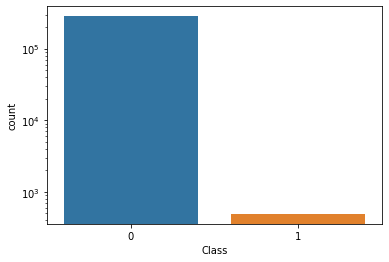

In [61]:
import seaborn as sn
ax=sn.countplot(x='Class',data=dataset);
ax.set_yscale('log')

## Undersampling
Dado que la base de datos está enormemente desbalanceada, para que el aprendizaje sea efectivo debemos equilibrar el número de fraudes y no fraudes. Para ello, usamos la técnica de <i>undersampling</i>. También existe el <i>upsampling</i> pero en este caso hemos probado con <i>undersampling</i> ya que, cuando analizamos resultados con ambas técnicas en fase de preprocesamiento, arrojó mejores resultados el <i>undersampling</i>.

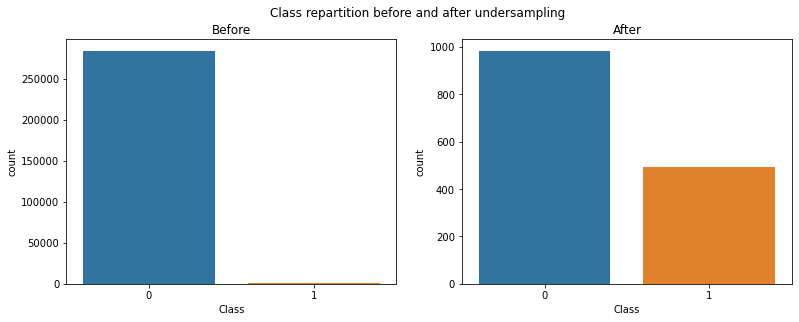

In [62]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler 

undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=2)

cols = dataset.columns.tolist()
cols = [c for c in cols if c not in ["Class"]]
target = "Class"

#define X and Y
X = dataset[cols]
Y = dataset[target]

#undersample
X_under, Y_under = undersample.fit_resample(X, Y)
test = pd.DataFrame(Y_under, columns = ['Class'])

fig, axs = plt.subplots(ncols=2, figsize=(13,4.5))
sn.countplot(x="Class", data=dataset, ax=axs[0])
sn.countplot(x="Class", data=test, ax=axs[1])

fig.suptitle("Class repartition before and after undersampling")
a1=fig.axes[0]
a1.set_title("Before")
a2=fig.axes[1]
a2.set_title("After")

dataset = pd.concat([X_under, Y_under], axis=1)

## Creación de sets(train, valid y test)
Dividiremos la base de datos, en tres grupos principales:
* Train: lo usaremos para entrenar la red.
* Valid: lo usaremos para mejorar la arquitectura de la red
* Test: es el conjunto final de datos para comprobar el rendimiento real de nuestra red. 

In [63]:
from pandas import DataFrame

# Data preprocessing
train_size = 0.75
test_size = 1 - train_size
train, test = train_test_split(dataset, test_size = test_size)
patterns_input = train.iloc[:,1:30].values[:]
input_test = test.iloc[:,1:30].values[:]

patterns_target = train.iloc[:,-1].values[:]
target_test = test['Class'].values[:]

input_train, input_valid, target_train, target_valid = train_test_split(
    patterns_input, patterns_target, train_size=train_size, test_size=test_size,
    random_state=0, shuffle=True)

print(input_train.shape, target_train.shape)
print(input_valid.shape, target_valid.shape)

(830, 29) (830,)
(277, 29) (277,)


## Perceptrón Simple

In [64]:
max_iter = 30
per = Perceptron(max_iter=max_iter, shuffle=False, random_state=0, verbose=True)
per.fit(input_train, target_train)
predict_train = per.predict(input_train)
predict_valid = per.predict(input_valid)
print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))

-- Epoch 1
Norm: 704.05, NNZs: 29, Bias: -154.000000, T: 830, Avg. loss: 12028.043337
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 1214.35, NNZs: 29, Bias: -303.000000, T: 1660, Avg. loss: 11367.581778
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 1639.79, NNZs: 29, Bias: -427.000000, T: 2490, Avg. loss: 9841.589524
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 1943.75, NNZs: 29, Bias: -545.000000, T: 3320, Avg. loss: 9837.572932
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 2250.70, NNZs: 29, Bias: -665.000000, T: 4150, Avg. loss: 10146.191762
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 2458.11, NNZs: 29, Bias: -762.000000, T: 4980, Avg. loss: 9752.722185
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 2667.01, NNZs: 29, Bias: -868.000000, T: 5810, Avg. loss: 10220.398237
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 2982.49, NNZs: 29, Bias: -979.000000, T: 6640, Avg. loss: 12094.048832
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 3285

Learning a MLP with 60 hidden neurons, 300 maximum number of iterations and 0.00100000 learning rate ...
Iteration 5, train loss = 4.66364454, valid loss = 4.42734913
Iteration 10, train loss = 0.88917510, valid loss = 1.03120056
Iteration 15, train loss = 0.45223464, valid loss = 0.47589108
Iteration 20, train loss = 0.36337968, valid loss = 0.38669801
Iteration 25, train loss = 0.27420939, valid loss = 0.31358094
Iteration 30, train loss = 0.21020491, valid loss = 0.25171336
MLPClassifier(hidden_layer_sizes=(60,), random_state=0, shuffle=False)
Visualizing the Cost Function Trajectory


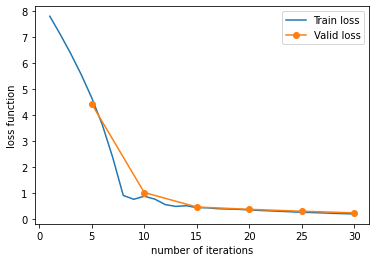

In [65]:
max_iter = 30

def MLP_train_valid(mlp, input_train, target_train, input_valid, target_valid, max_iter, valid_cycles, verbose):
    """
    Train and valid MLP every valid_cycles iterations
    """
    classes = np.unique(target_train)
    loss_valid = []
    for i in range(6):
        for j in range(valid_cycles):
            out = mlp.partial_fit(input_train, target_train, classes)
            # Calculate loss function of valid set
        last_lost_valid = log_loss(target_valid, mlp.predict_proba(input_valid))
        loss_valid.append(last_lost_valid)
        if verbose:
            print("Iteration %d, train loss = %.8f, valid loss = %.8f" %
                  (mlp.n_iter_, mlp.loss_, last_lost_valid))
        if early_stopping and (i > 0) and (last_lost_valid > loss_valid[-2]): # Early stopping
            if verbose:
                print("Early stopping: Validation score did not improve")
            break
    if verbose: 
        print(out)
        print("Visualizing the Cost Function Trajectory")
        plt.plot(range(1, len(mlp.loss_curve_)+1), mlp.loss_curve_, label='Train loss')
        plt.plot(range(valid_cycles,len(loss_valid)*valid_cycles+valid_cycles,valid_cycles), loss_valid, '-o', label='Valid loss')
        plt.xlabel('number of iterations')
        plt.ylabel('loss function')
        plt.legend(loc='upper right')
        plt.show()

n_hidden = 60
max_iter = 300
learning_rate_init = 0.001
valid_cycles = 5
early_stopping = True

print("Learning a MLP with %d hidden neurons, %d maximum number of iterations and %.8f learning rate ..." % (n_hidden, max_iter, learning_rate_init))

mlp = MLPClassifier(hidden_layer_sizes=(n_hidden,), learning_rate_init=learning_rate_init, shuffle=False, random_state=0, verbose=False)

MLP_train_valid(mlp, input_train, target_train, input_valid, target_valid, max_iter, valid_cycles, True)


In [66]:
predict_train = mlp.predict(input_train)
predict_valid = mlp.predict(input_valid)
print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))
print("Train confusion matrix:")
print(confusion_matrix(target_train, predict_train))
print("Valid confusion matrix:")
print(confusion_matrix(target_valid, predict_valid))
print("Train classification report:")
print(classification_report(target_train, predict_train))
print("Valid classification report:")
print(classification_report(target_valid, predict_valid))

Train accuracy: 95.301%
Valid accuracy: 92.058%
Train confusion matrix:
[[535  12]
 [ 27 256]]
Valid confusion matrix:
[[181   9]
 [ 13  74]]
Train classification report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       547
           1       0.96      0.90      0.93       283

    accuracy                           0.95       830
   macro avg       0.95      0.94      0.95       830
weighted avg       0.95      0.95      0.95       830

Valid classification report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       190
           1       0.89      0.85      0.87        87

    accuracy                           0.92       277
   macro avg       0.91      0.90      0.91       277
weighted avg       0.92      0.92      0.92       277



## Optimización ratio de aprendizaje

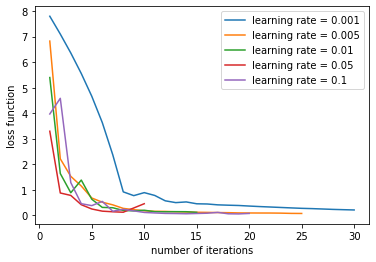

In [67]:
tests_learning_rate_init = [0.001, 0.005, 0.01, 0.05, 0.1]
activation = 'relu'
random_state = 0
now = datetime.now()
loss_curves =  []
for lr in tests_learning_rate_init:
   mlp = MLPClassifier(hidden_layer_sizes=(n_hidden,), learning_rate_init=lr, shuffle=False, random_state=random_state, verbose=False, activation=activation)
   MLP_train_valid(mlp, input_train, target_train, input_valid, target_valid, max_iter, valid_cycles, False)
   loss_curves.append(mlp.loss_curve_)
for (lr, loss_curve) in zip(tests_learning_rate_init, loss_curves):
   plt.plot(range(1, len(loss_curve)+1), loss_curve, label='learning rate = ' + str(lr))
plt.xlabel('number of iterations')
plt.ylabel('loss function')
plt.legend(loc='upper right')
plt.show()


## Optimización arquitectura

In [68]:
tests_n_hidden = [10, 30, 50, 70, 90, 110, 130, 150, 170, 190]
n_reps = 10
activation = 'relu'
# activation = 'logistic'
learning_rate_init = 0.01
now = datetime.now()
best_mlp = []
best_acc = 0.0
accs_train = []
accs_valid = []
for n_hidden in tests_n_hidden:
   max_acc_train = max_acc_valid = 0.0
   for random_state in range(n_reps):
       mlp = MLPClassifier(hidden_layer_sizes=(n_hidden,), learning_rate_init=learning_rate_init, shuffle=False, random_state=random_state, verbose=False, activation=activation)
       MLP_train_valid(mlp, input_train, target_train, input_valid, target_valid, max_iter, valid_cycles, False)
       
       acc_train = accuracy_score(target_train, mlp.predict(input_train))
       acc_valid = accuracy_score(target_valid,mlp.predict(input_valid))
       print("Seed = %d, train acc = %.8f, valid acc = %.8f, iterations = %d" % (random_state, acc_train, acc_valid, len(mlp.loss_curve_)))
       if (max_acc_valid < acc_valid):
           max_acc_valid = acc_valid
           max_acc_train = acc_train
           if (acc_valid > best_acc):
               best_acc = acc_valid
               best_mlp = mlp
   accs_train.append(max_acc_train)
   accs_valid.append(max_acc_valid)
   print("Number hidden units = %i, train acc = %.8f, max valid acc = %.8f" % (n_hidden, max_acc_train, max_acc_valid))
print("Number of seconds for training: %d" % (datetime.now() - now).total_seconds())
print("Best MLP valid accuracy: %.8f%%" % (best_acc * 100))
print("Best MLP: ", best_mlp)

Seed = 0, train acc = 0.96265060, valid acc = 0.94584838, iterations = 30
Seed = 1, train acc = 0.96144578, valid acc = 0.93501805, iterations = 30
Seed = 2, train acc = 0.96265060, valid acc = 0.93501805, iterations = 30
Seed = 3, train acc = 0.96506024, valid acc = 0.93501805, iterations = 25
Seed = 4, train acc = 0.94939759, valid acc = 0.90252708, iterations = 15
Seed = 5, train acc = 0.96385542, valid acc = 0.94584838, iterations = 20
Seed = 6, train acc = 0.97108434, valid acc = 0.92418773, iterations = 30
Seed = 7, train acc = 0.96385542, valid acc = 0.93501805, iterations = 30
Seed = 8, train acc = 0.96265060, valid acc = 0.93140794, iterations = 30
Seed = 9, train acc = 0.97349398, valid acc = 0.93501805, iterations = 25
Number hidden units = 10, train acc = 0.96265060, max valid acc = 0.94584838
Seed = 0, train acc = 0.96867470, valid acc = 0.92779783, iterations = 20
Seed = 1, train acc = 0.94819277, valid acc = 0.90613718, iterations = 15
Seed = 2, train acc = 0.98192771, v

## Resultados de las distintas redes con número de neuronas ocultas distinto

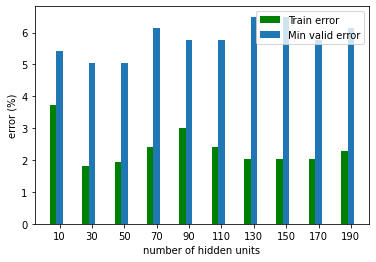

In [69]:
width = 4
plt.bar(np.array(tests_n_hidden) - width, 100 *(1- np.array(accs_train)), color='g', width=width, label='Train error')
plt.bar(np.array(tests_n_hidden), 100 *(1- np.array(accs_valid)), width=width, label='Min valid error')
plt.xlabel('number of hidden units')
plt.ylabel('error (%)')
plt.xticks(np.array(tests_n_hidden), tests_n_hidden)
plt.legend(loc='upper right')
plt.show()

In [70]:
print("Printing final results")

predict_train = best_mlp.predict(input_train)
predict_valid = best_mlp.predict(input_valid)
predict_test = best_mlp.predict(input_test)

print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))
print("Test accuracy: %.3f%%" % (accuracy_score(target_test, predict_test) * 100))

print("Train confusion matrix:")
print(confusion_matrix(target_train, predict_train))
print("Valid confusion matrix:")
print(confusion_matrix(target_valid, predict_valid))
print("Test confusion matrix:")
print(confusion_matrix(target_test, predict_test))

print("Train classification report:")
print(classification_report(target_train, predict_train))
print("Valid classification report:")
print(classification_report(target_valid, predict_valid))
print("Test classification report:")
print(classification_report(target_test, predict_test))

Printing final results
Train accuracy: 98.193%
Valid accuracy: 94.946%
Test accuracy: 95.122%
Train confusion matrix:
[[547   0]
 [ 15 268]]
Valid confusion matrix:
[[186   4]
 [ 10  77]]
Test confusion matrix:
[[241   6]
 [ 12 110]]
Train classification report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       547
           1       1.00      0.95      0.97       283

    accuracy                           0.98       830
   macro avg       0.99      0.97      0.98       830
weighted avg       0.98      0.98      0.98       830

Valid classification report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       190
           1       0.95      0.89      0.92        87

    accuracy                           0.95       277
   macro avg       0.95      0.93      0.94       277
weighted avg       0.95      0.95      0.95       277

Test classification report:
              precision   

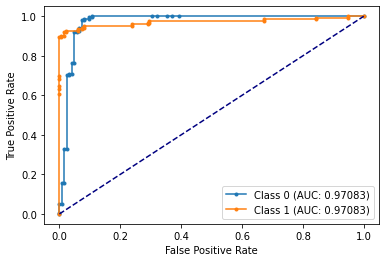

In [71]:
mlp_probs = mlp.predict_proba(input_test)
classes  = np.unique(target_train)
mlp_auc = []
mlp_fpr = []
mlp_tpr = []
for cla in classes:
   mlp_auc.append(roc_auc_score(target_test==cla, mlp_probs[:,cla]))
   fpr, tpr, _ = roc_curve(target_test==cla, mlp_probs[:,cla])
   mlp_fpr.append(fpr)
   mlp_tpr.append(tpr)
for cla in classes:
   # plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
   plt.plot(mlp_fpr[cla], mlp_tpr[cla], marker='.', label='Class %d (AUC: %.5f)' % (cla, mlp_auc[cla]))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [72]:
real_class = 1
indxs = np.where(test['Class'].values[:] == real_class)[0]
indxs_err = indxs[(np.where(predict_test[(indxs)] != real_class)[0])]
preds_err = predict_test[(indxs_err)]
print(indxs_err)

[ 33  89 103 159 229 246 275 314 336 346 359 365]
